# Session 10: Using Ragas to Evaluate an Agent Application built with LangChain and LangGraph

In the following notebook, we'll be looking at how [Ragas](https://github.com/explodinggradients/ragas) can be helpful in a number of ways when looking to evaluate your RAG applications!

While this example is rooted in LangChain/LangGraph - Ragas is framework agnostic (you don't even need to be using a framework!).

We'll:

- Collect our data
- Create a simple Agent application
- Evaluate our Agent application

> NOTE: This notebook is very lightly modified from Ragas' [LangGraph tutorial](https://docs.ragas.io/en/stable/howtos/integrations/_langgraph_agent_evaluation/)!

## 🤝 Breakout Room #2
  - Task 1: Installing Required Libraries
  - Task 2: Set Environment Variables
  - Task 3: Building a ReAct Agent with Metal Price Tool
  - Task 4: Implementing the Agent Graph Structure
  - Task 5: Converting Agent Messages to Ragas Evaluation Format
  - Task 6: Evaluating the Agent's Performance using Ragas Metrics
  - ***Activity #1: Evaluate Tool Call Accuracy***
  - ***Activity #2: Evaluate Topic Adherence***

## Task 1: Installing Required Libraries

If you have not already done so, install the required libraries using the uv package manager:
``` bash

uv sync

```

## Task 2: Set Environment Variables:

We'll also need to provide our API keys.
> NOTE: In addition to OpenAI's models, this notebook will be creating a metals pricing tool using the API from metals.dev. Please be sure to sign up for an account on [metals.dev](https://metals.dev/) to get your API key.
You have two options for supplying your API keys in this session:
- Use environment variables (see Prerequisite #2 in the README.md)
- Provide them via a prompt when the notebook runs

The following code will load all of the environment variables in your `.env`. Then, it checks for the two API keys we need. If they are not there, it will prompt you to provide them.

First, OpenAI's for our LLM/embedding model combination!

Second, metals.dev's for our metals pricing tool.


In [4]:
import os
from getpass import getpass
from dotenv import load_dotenv

load_dotenv()

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API key!")

if not os.environ.get("METAL_API_KEY"):
    os.environ["METAL_API_KEY"] = getpass("Please enter your metals.dev API key!")

## Task 3: Building a ReAct Agent with Metal Price Tool

### Define the get_metal_price Tool

The get_metal_price tool will be used by the agent to fetch the price of a specified metal. We'll create this tool using the @tool decorator from LangChain.

In [5]:
from langchain_core.tools import tool
import requests
from requests.structures import CaseInsensitiveDict
import os


# Define the tools for the agent to use
@tool
def get_metal_price(metal_name: str) -> float:
    """Fetches the current per gram price of the specified metal.

    Args:
        metal_name : The name of the metal (e.g., 'gold', 'silver', 'platinum').

    Returns:
        float: The current price of the metal in dollars per gram.

    Raises:
        KeyError: If the specified metal is not found in the data source.
    """
    try:
        metal_name = metal_name.lower().strip()
        url = f"https://api.metals.dev/v1/latest?api_key={os.environ['METAL_API_KEY']}&currency=USD&unit=toz"
        headers = CaseInsensitiveDict()
        headers["Accept"] = "application/json"
        resp = requests.get(url, headers=headers)
        print(resp)
        metal_price = resp.json()["metals"]
        if metal_name not in metal_price:
            raise KeyError(
                f"Metal '{metal_name}' not found. Available metals: {', '.join(metal_price['metals'].keys())}"
            )
        return metal_price[metal_name]
    except Exception as e:
        raise Exception(f"Error fetching metal price: {str(e)}")

### Binding the Tool to the LLM
With the get_metal_price tool defined, the next step is to bind it to the ChatOpenAI model. This enables the agent to invoke the tool during its execution based on the user's requests allowing it to interact with external data and perform actions beyond its native capabilities.

In [6]:
from langchain_openai import ChatOpenAI

tools = [get_metal_price]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

## Task 4: Implementing the Agent Graph Structure

In LangGraph, state plays a crucial role in tracking and updating information as the graph executes. As different parts of the graph run, the state evolves to reflect the changes and contains information that is passed between nodes.

For example, in a conversational system like this one, the state is used to track the exchanged messages. Each time a new message is generated, it is added to the state and the updated state is passed through the nodes, ensuring the conversation progresses logically.

### Defining the State
To implement this in LangGraph, we define a state class that maintains a list of messages. Whenever a new message is produced it gets appended to this list, ensuring that the conversation history is continuously updated.

In [7]:
from langgraph.graph import END
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Defining the should_continue Function
The `should_continue` function determines whether the conversation should proceed with further tool interactions or end. Specifically, it checks if the last message contains any tool calls (e.g., a request for metal prices).

- If the last message includes tool calls, indicating that the agent has invoked an external tool, the conversation continues and moves to the "tools" node.
- If there are no tool calls, the conversation ends, represented by the END state.

In [8]:
# Define the function that determines whether to continue or not
def should_continue(state: GraphState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

### Calling the Model
The `call_model` function interacts with the Language Model (LLM) to generate a response based on the current state of the conversation. It takes the updated state as input, processes it and returns a model-generated response.

In [7]:
# Define the function that calls the model
def call_model(state: GraphState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

### Creating the Assistant Node
The `assistant` node is a key component responsible for processing the current state of the conversation and using the Language Model (LLM) to generate a relevant response. It evaluates the state, determines the appropriate course of action, and invokes the LLM to produce a response that aligns with the ongoing dialogue.

In [9]:
# Node
def assistant(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

### Creating the Tool Node
The `tool_node` is responsible for managing interactions with external tools, such as fetching metal prices or performing other actions beyond the LLM's native capabilities. The tools themselves are defined earlier in the code, and the tool_node invokes these tools based on the current state and the needs of the conversation.

In [10]:
from langgraph.prebuilt import ToolNode

# Node
tools = [get_metal_price]
tool_node = ToolNode(tools)

### Building the Graph
The graph structure is the backbone of the agentic workflow, consisting of interconnected nodes and edges. To construct this graph, we use the StateGraph builder which allows us to define and connect various nodes. Each node represents a step in the process (e.g., the assistant node, tool node) and the edges dictate the flow of execution between these steps.

In [11]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

# Define a new graph for the agent
builder = StateGraph(GraphState)

# Define the two nodes we will cycle between
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

# Set the entrypoint as `agent`
builder.add_edge(START, "assistant")

# Making a conditional edge
# should_continue will determine which node is called next.
builder.add_conditional_edges("assistant", should_continue, ["tools", END])

# Making a normal edge from `tools` to `agent`.
# The `agent` node will be called after the `tool`.
builder.add_edge("tools", "assistant")

# Compile and display the graph for a visual overview
react_graph = builder.compile()

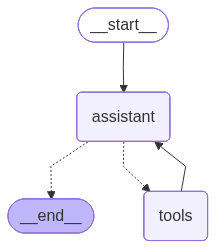

In [12]:
react_graph

To test our setup, we will run the agent with a query. The agent will fetch the price of copper using the metals.dev API.

In [13]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What is the price of copper?")]
result = react_graph.invoke({"messages": messages})

<Response [200]>


In [13]:
result["messages"]

[HumanMessage(content='What is the price of copper?', additional_kwargs={}, response_metadata={}, id='dd969b5b-0d5f-4ea0-9243-0078c73a2f01'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Vtd4aN6oS6Cy3MJlBdPrnOnt', 'function': {'arguments': '{"metal_name":"copper"}', 'name': 'get_metal_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 116, 'total_tokens': 134, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f4ae844694', 'id': 'chatcmpl-D8cXBn2M68RPXyMuYfT5ZQhzUe63P', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--019c54ac-8df2-7fc1-a672-c440e5209bb9-0', tool_calls=[{'name': 'get_metal_price', 'args': {'metal_name': 'copper'}, 'id

## Task 5: Converting Agent Messages to Ragas Evaluation Format

In the current implementation, the GraphState stores messages exchanged between the human user, the AI (LLM's responses), and any external tools (APIs or services the AI uses) in a list. Each message is an object in LangChain's format

```python
# Implementation of Graph State
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
```

Each time a message is exchanged during agent execution, it gets added to the messages list in the GraphState. However, Ragas requires a specific message format for evaluating interactions.

Ragas uses its own format to evaluate agent interactions. So, if you're using LangGraph, you will need to convert the LangChain message objects into Ragas message objects. This allows you to evaluate your AI agents with Ragas’ built-in evaluation tools.

**Goal:**  Convert the list of LangChain messages (e.g., HumanMessage, AIMessage, and ToolMessage) into the format expected by Ragas, so the evaluation framework can understand and process them properly.

To convert a list of LangChain messages into a format suitable for Ragas evaluation, Ragas provides the function [convert_to_ragas_messages][ragas.integrations.langgraph.convert_to_ragas_messages], which can be used to transform LangChain messages into the format expected by Ragas.

Here's how you can use the function:

In [29]:
from ragas.integrations.langgraph import convert_to_ragas_messages

# Assuming 'result["messages"]' contains the list of LangChain messages
ragas_trace = convert_to_ragas_messages(result["messages"])

In [30]:
ragas_trace  # List of Ragas messages

[HumanMessage(content='What is the price of copper?', metadata=None, type='human'),
 AIMessage(content='', metadata=None, type='ai', tool_calls=[ToolCall(name='get_metal_price', args={'metal_name': 'copper'})]),
 ToolMessage(content='0.412', metadata=None, type='tool'),
 AIMessage(content='The price of copper is $0.412 per gram.', metadata=None, type='ai', tool_calls=[])]

### ❓ Question #1:

Describe in your own words what a "trace" is.

##### Answer:

It is a chronological sequence of messages and actions --> a full record of what happened during one agent execution. 

It includes user input, model reasoning, tool calls, tool outputs, final response.

## Task 6: Evaluating the Agent's Performance  using Ragas Metrics

For this tutorial, let us evaluate the Agent with the following metrics:

- [Tool call Accuracy](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/#tool-call-accuracy):ToolCallAccuracy is a metric that can be used to evaluate the performance of the LLM in identifying and calling the required tools to complete a given task.  

- [Agent Goal accuracy](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/#agent-goal-accuracy): Agent goal accuracy is a metric that can be used to evaluate the performance of the LLM in identifying and achieving the goals of the user. This is a binary metric, with 1 indicating that the AI has achieved the goal and 0 indicating that the AI has not achieved the goal.
- [Topic Adherence](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/): Topic adherence is a metric that can be used to ensure the Agent system is staying "on-topic", meaning that it's not straying from the intended use case. You can think of this as a kinda of faithfulness, where the responses of the LLM should stay faithful to the topic provided.


First, let us actually run our Agent with a couple of queries, and make sure we have the ground truth labels for these queries.

### ❓ Question #2:

Describe *how* each of the above metrics are calculated. This will require you to read the documentation for each metric.

##### Answer:

**Tool call accuracy** --> measures whether right tools are called with right parameters.

Two modes:
- Strict order --> for sequential workflows, where tools need to be called in a specific order
- Flexible order --> for parallel operations, where order doesn't matter.

Caluclating it requires two inputs: user input, expected tool calls.
Score ranges from 0 to 1.
Score  = (argument accuracy) * (sequence aligned ? 1 : 0)

**Agent goal accuracy** --> measures whether agent identifies and achieves the goal of the request (user query).
It's a binary metri: either 0 or 1.

It can be calculated in two ways:
- With reference: compares the agent end state with the provided reference outcome.
- Without reference: infers both the user's goal and the intended outcome from the conversation and compares them.


**Topic adherence** --> measures how well the agent stays on the topic. It requires a predefined set of reference topics along with the user input, in order to compute this metric.

This metric can compute the following for topic adherence:
- Precision
- Recall
- F1

Precision = (Queries that are answered and adhered to the reference topics) / (Queries that are answered)

Recall = (Queries that are answered and adhered to the reference topics) / (Queries that are answered and adhered to the reference topics + Queries that were refused but should have been answered)

F1 = (2 * Precision * Recall) / (Precision + Recall)


### Tool Call Accuracy

In [14]:
from ragas.metrics import ToolCallAccuracy
from ragas.dataset_schema import MultiTurnSample
from ragas.integrations.langgraph import convert_to_ragas_messages
import ragas.messages as r


ragas_trace = convert_to_ragas_messages(
    messages=result["messages"]
)  # List of Ragas messages converted using the Ragas function

sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_tool_calls=[
        r.ToolCall(name="get_metal_price", args={"metal_name": "copper"})
    ],
)

tool_accuracy_scorer = ToolCallAccuracy()
tool_accuracy_scorer.llm = ChatOpenAI(model="gpt-4o-mini")
await tool_accuracy_scorer.multi_turn_ascore(sample)

/Users/sireeshapulipati/AIE9/10_Evaluating_RAG_With_Ragas/.venv/lib/python3.13/site-packages/pysbd/segmenter.py:66: SyntaxWarning: invalid escape sequence '\s'
  for match in re.finditer('{0}\s*'.format(re.escape(sent)), self.original_text):
/Users/sireeshapulipati/AIE9/10_Evaluating_RAG_With_Ragas/.venv/lib/python3.13/site-packages/pysbd/lang/arabic.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/Users/sireeshapulipati/AIE9/10_Evaluating_RAG_With_Ragas/.venv/lib/python3.13/site-packages/pysbd/lang/persian.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)


1.0

Tool Call Accuracy: 1, because the LLM correctly identified and used the necessary tool (get_metal_price) with the correct parameters (i.e., metal name as "copper").

### Agent Goal Accuracy

In [16]:
messages = [HumanMessage(content="What is the price of 10 grams of silver?")]

result = react_graph.invoke({"messages": messages})

<Response [200]>


In [19]:
result["messages"]  # List of Langchain messages

[HumanMessage(content='What is the price of 10 grams of silver?', additional_kwargs={}, response_metadata={}, id='92619fe7-0e9a-43a1-a037-c34f2f9a41c5'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VNOvrCOiCQQ3eaV1vgARafPT', 'function': {'arguments': '{"metal_name":"silver"}', 'name': 'get_metal_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 120, 'total_tokens': 137, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f4ae844694', 'id': 'chatcmpl-D8cdL6kaMKgA2MrXVv6zIl6gOXGsE', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--019c54b2-621a-7172-95e8-c2f33311f9d4-0', tool_calls=[{'name': 'get_metal_price', 'args': {'metal_name': 's

In [20]:
from ragas.integrations.langgraph import convert_to_ragas_messages

ragas_trace = convert_to_ragas_messages(
    result["messages"]
)  # List of Ragas messages converted using the Ragas function
ragas_trace

[HumanMessage(content='What is the price of 10 grams of silver?', metadata=None, type='human'),
 AIMessage(content='', metadata=None, type='ai', tool_calls=[ToolCall(name='get_metal_price', args={'metal_name': 'silver'})]),
 ToolMessage(content='77.2965', metadata=None, type='tool'),
 AIMessage(content='The current price of silver is approximately $77.30 per gram. Therefore, the price of 10 grams of silver would be about $773.00.', metadata=None, type='ai', tool_calls=[])]

In [21]:
from ragas.dataset_schema import MultiTurnSample
from ragas.metrics import AgentGoalAccuracyWithReference
from ragas.llms import LangchainLLMWrapper


sample = MultiTurnSample(
    user_input=ragas_trace,
    reference="Price of 10 grams of silver",
)

scorer = AgentGoalAccuracyWithReference()

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
scorer.llm = evaluator_llm
await scorer.multi_turn_ascore(sample)

1.0

Agent Goal Accuracy: 1, because the LLM correctly achieved the user’s goal of retrieving the price of 10 grams of silver.

### Topic Adherence



In [22]:
messages = [HumanMessage(content="How fast can an eagle fly?")]

result = react_graph.invoke({"messages": messages})

In [23]:
result["messages"]

[HumanMessage(content='How fast can an eagle fly?', additional_kwargs={}, response_metadata={}, id='a9bcde2b-c9e2-469b-bdab-c9ba93e3fa7f'),
 AIMessage(content='Eagles are known for their impressive flying abilities. Generally, they can fly at speeds of 30 to 50 miles per hour (48 to 80 kilometers per hour) during normal flight. However, when they are diving to catch prey, some species, such as the golden eagle, can reach speeds of over 150 miles per hour (241 kilometers per hour).', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 116, 'total_tokens': 191, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f4ae844694', 'id': 'chatcmpl-D8e6dFLGf7Q805tOFdDrrJYa1jNUK', 'service_tier': 'default', 'finish_reas

In [24]:
from ragas.integrations.langgraph import convert_to_ragas_messages

ragas_trace = convert_to_ragas_messages(
    result["messages"]
)  # List of Ragas messages converted using the Ragas function
ragas_trace

[HumanMessage(content='How fast can an eagle fly?', metadata=None, type='human'),
 AIMessage(content='Eagles are known for their impressive flying abilities. Generally, they can fly at speeds of 30 to 50 miles per hour (48 to 80 kilometers per hour) during normal flight. However, when they are diving to catch prey, some species, such as the golden eagle, can reach speeds of over 150 miles per hour (241 kilometers per hour).', metadata=None, type='ai', tool_calls=[])]

In [25]:
from ragas.metrics import TopicAdherenceScore

sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_topics = ["metals"]
)

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
scorer = TopicAdherenceScore(llm = evaluator_llm, mode="precision")
await scorer.multi_turn_ascore(sample)

np.float64(0.0)

As we can see, the current implementation fails due to talking about birds, when it should be talking about metal!

### ❓ Question #3:

If you were deploying this metal price agent as a production wellness assistant (imagine it's a financial wellness tool for tracking investment metals), what are the implications of each metric (Tool Call Accuracy, Agent Goal Accuracy, Topic Adherence) for user trust and safety?

##### Answer:

For a production Financial Wellness assistant application, 

Tool call accuracy --> ensures that the metal prices are retrieved by calling the metals tool, and not just hallucinated or retrieved from another tool such as web search. The accuracy of the metal prices is really important for the agent to provide right financial investment suggestion or for the user to made right decisions about the metals investments. 
So, Tool call accuracy metric is very important for user trust. Not so much for safety because inaccurate metal price information is not likely to cause any harm to the user (except potential financial harm, if the user acts on incorrect information.)


Agent goal accuracy --> user trust is affected adversely if this metric is 0, i.e., the agent doesn't aidentify and achieve the user goal. If the user asks the agent to compare the prices of top 10 precious metals, and the agent responded with generic financial health information, then the user is likely to be frustrated and lose trust in the agent.

Topic adherence ---> When the user asks for monthly budgeting strategies, and the assistant responds with how the user needs let go of worldly attachments to achieve nirvana (provides spiritual guidance), it is not adhereing to the topic. Will leave the user confused and frustrated. And the user will have low trust in this agent.

### ❓ Question #4:

How would you design a comprehensive test suite for evaluating this metal price agent? What test cases would you include to ensure robustness across the three metrics (Tool Call Accuracy, Agent Goal Accuracy, Topic Adherence)?

##### Answer:

**Tool call accuracy**:
- if the user mispells the metal name or 
- if the user specifies scientific names or symbols (like Au for gold)

**Agent goal accuracy**:
Try with different goals like
- Comparing prices of 2 or more metals
- Ranking metals by price (ex: top 3 most expensive metals)

**Topic adherence**:
- related but not the reference topic. Ex: asking about metal jewelry prices; other elements in periodic table
- off-topic such as about stocks or financial advice

## Activity #1: Evaluate Tool Call Accuracy with a New Query

Create a new test case for Tool Call Accuracy. Run the agent with a different metal query (e.g., "What is the price of platinum?") and evaluate its tool call accuracy.

**Requirements:**
1. Create a new query for the agent
2. Run the agent and collect the trace
3. Define the expected reference tool calls
4. Evaluate using ToolCallAccuracy
5. Document your results

In [27]:
### YOUR CODE HERE ###

from ragas.metrics import ToolCallAccuracy
from ragas.dataset_schema import MultiTurnSample
from langchain_core.messages import HumanMessage
from ragas.integrations.langgraph import convert_to_ragas_messages
import ragas.messages as r


# 1. Create a new query
messages = [HumanMessage(content="What is the price of platinum?")]

# 2. Run the agent
result = react_graph.invoke({"messages": messages})


# 3. Convert to Ragas format
ragas_trace_tca = convert_to_ragas_messages(
    messages=result["messages"]
) 

# 4. Create MultiTurnSample with reference_tool_calls
sample_tca = MultiTurnSample(
    user_input=ragas_trace_tca,
    reference_tool_calls=[
        r.ToolCall(name="get_metal_price", args={"metal_name": "platinum"})
    ],
)

# 5. Evaluate with ToolCallAccuracy
tool_accuracy_scorer = ToolCallAccuracy()
tool_accuracy_scorer.llm = ChatOpenAI(model="gpt-4o-mini")
tca_score = await tool_accuracy_scorer.multi_turn_ascore(sample_tca)

print(result["messages"][-1].content)
print(f"Tool Call Accuracy: {tca_score}")

<Response [200]>
The current price of platinum is approximately $2008.41 per gram.
Tool Call Accuracy: 1.0


## Activity #2: Evaluate Topic Adherence with an On-Topic Query

Create a test case that should PASS the Topic Adherence check. Run the agent with a metals-related query and verify it stays on topic.

**Requirements:**
1. Create a metals-related query for the agent
2. Run the agent and collect the trace
3. Create a MultiTurnSample with reference_topics=["metals"]
4. Evaluate using TopicAdherenceScore
5. The score should be 1.0 (or close to it) since the query is on-topic

In [28]:
### YOUR CODE HERE ###
from ragas.metrics import TopicAdherenceScore
from ragas.llms import LangchainLLMWrapper

# 1. Create a metals-related query
messages = [HumanMessage(content="What is the price of gold?")]

# 2. Run the agent
result = react_graph.invoke({"messages": messages})

# 3. Convert to Ragas format
ragas_trace_ta = convert_to_ragas_messages(
    messages=result["messages"]
) 

# 4. Create MultiTurnSample with reference_topics=["metals"]
sample_ta = MultiTurnSample(
    user_input=ragas_trace_ta,
    reference_topics=["metal prices", "metals", "precious metals"]
)

# 5. Evaluate with TopicAdherenceScore
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
scorer = TopicAdherenceScore(llm = evaluator_llm, mode="precision")
ta_score = await scorer.multi_turn_ascore(sample_ta)

print(result["messages"][-1].content)
print(f"Topic Adherence Score: {ta_score}")



<Response [200]>
The current price of gold is $4877.44 per gram.
Topic Adherence Score: 0.9999999999


In [29]:
# 4. Create MultiTurnSample with reference_topics=["metals"]
sample_ta1 = MultiTurnSample(
    user_input=ragas_trace_ta,
    reference_topics=["metals"]
)

# 5. Evaluate with TopicAdherenceScore
scorer = TopicAdherenceScore(llm = evaluator_llm, mode="precision")
ta_score1 = await scorer.multi_turn_ascore(sample_ta1)

print(result["messages"][-1].content)
print(f"Topic Adherence Score: {ta_score1}")

The current price of gold is $4877.44 per gram.
Topic Adherence Score: 0.0


In [ ]:
# 4. Create MultiTurnSample with reference_topics=["metals"]
sample_ta2 = MultiTurnSample(
    user_input=ragas_trace_ta,
    reference_topics=["metals", "metal prices"]
)

# 5. Evaluate with TopicAdherenceScore
scorer = TopicAdherenceScore(llm = evaluator_llm, mode="precision") #recall also doesn't work
ta_score2 = await scorer.multi_turn_ascore(sample_ta2)

print(result["messages"][-1].content)
print(f"Topic Adherence Score: {ta_score2}")

The current price of gold is $4877.44 per gram.
Topic Adherence Score: 0.0
